# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
import numpy as np
import pandas as pd
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

from model import Actor, Critic
from ddpg_agent import Agent

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train the agents with Multi Agent Deep Deterministic Policy Gradient (AMDDPG)

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# initialize agents
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=40)

In [14]:
def ddpg_tennis(n_episodes=1500, max_t=1000, train_mode=True, print_every=100):      
    scores_deque = deque(maxlen=print_every)
    scores, ma_scores = [], []
    achieved = False

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations            # get the current state
        episode_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states)          # select an action
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            agent.step(states, actions, rewards, next_states, dones) # take step with agent (including learning)
            episode_scores += rewards                                # update the score
            states = next_states                             # roll over the state to next time step
            if np.any(dones):                                       # exit loop if episode finished
                break
        
        scores_deque.append(np.max(episode_scores))       # save most recent score
        scores.append(np.max(episode_scores))
        ma_scores.append(np.mean(scores_deque)) # Moving average socres over 100 episodes

        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=0.5 and achieved is False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            achieved = True 
            
    return scores, ma_scores

In [15]:
scores, avg_scores = ddpg_tennis(n_episodes=2000)

Episode 100	Average Score: 0.0038
Episode 200	Average Score: 0.0351
Episode 300	Average Score: 0.0010
Episode 400	Average Score: 0.0000
Episode 500	Average Score: 0.0143
Episode 600	Average Score: 0.0519
Episode 700	Average Score: 0.0887
Episode 800	Average Score: 0.1002
Episode 900	Average Score: 0.0927
Episode 1000	Average Score: 0.0934
Episode 1100	Average Score: 0.1065
Episode 1200	Average Score: 0.0867
Episode 1300	Average Score: 0.0936
Episode 1400	Average Score: 0.1287
Episode 1496	Average Score: 0.5030
Environment solved in 1496 episodes!	Average Score: 0.5030
Episode 1500	Average Score: 0.5019
Episode 1600	Average Score: 1.3636
Episode 1700	Average Score: 1.1096
Episode 1800	Average Score: 1.4147
Episode 1900	Average Score: 1.0845
Episode 2000	Average Score: 1.4688


In [7]:
def plot_scores(scores, avg_scores, save_fig=False):
    """Plot scores and optional rolling mean using specified window."""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='scores')
    plt.plot(np.arange(len(scores)),avg_scores, label='mean scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(f'scores')
    plt.legend()

    if save_fig:
        plt.savefig(f'./images/figures_scores.png', bbox_inches='tight', pad_inches=0)

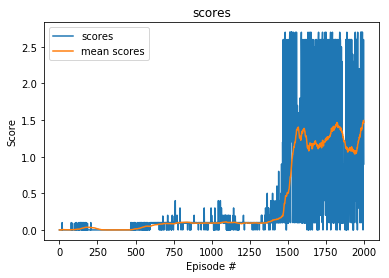

In [17]:
plot_scores(scores, avg_scores)

### 4. Test the trained model

In [7]:
# Load the saved weights into Pytorch model
agent.actor_local.load_state_dict(torch.load('./checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('./checkpoint_critic.pth', map_location='cpu'))

In [31]:
def ddpg_tennis_test(n_episodes=20, max_t=1000, train_mode=False, print_every=5):
    scores_window = deque(maxlen=10)
    scores_all = []
    score_ave = []  

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = env_info.vector_observations  # get states and combine them
        scores = np.zeros(num_agents)
        while True:
            actions = agent.act(states)            # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        score_ave.append(np.mean(scores_window))

        # print results
        if i_episode % print_every == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-print_every, i_episode, np.max(scores_all[-print_every:]), score_ave[-1]))
            
    return scores_all, score_ave 

In [32]:
scores, avg_scores = ddpg_tennis_test()

Episodes 0000-0005	Max Reward: 2.800	Moving Average: 1.900
Episodes 0005-0010	Max Reward: 5.200	Moving Average: 2.020
Episodes 0010-0015	Max Reward: 2.700	Moving Average: 1.920
Episodes 0015-0020	Max Reward: 5.200	Moving Average: 2.130


In [8]:
agent.actor_local.eval(), agent.critic_local.eval()

(Actor(
   (fc1): Linear(in_features=24, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=2, bias=True)
   (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ), Critic(
   (fcs1): Linear(in_features=24, out_features=128, bias=True)
   (fc2): Linear(in_features=130, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=1, bias=True)
   (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ))

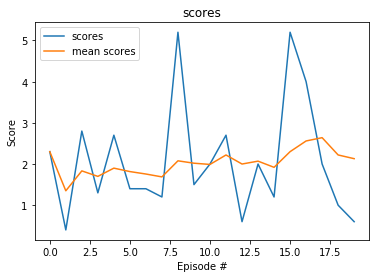

In [33]:
plot_scores(scores, avg_scores)

When finished, you can close the environment.

In [19]:
env.close()